In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

from math import exp, factorial
import seaborn as sns

In [3]:
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

In [4]:
# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
actions

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [5]:
# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()
def poisson(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache.keys():
        poisson_cache[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poisson_cache[key]

In [6]:
# @state: [# of cars in first location, # of cars in second location]
# @action: positive if moving cars from first location to second location,
#          negative if moving cars from second location to first location
# @stateValue: state value matrix
# @constant_returned_cars:  if set True, model is simplified such that
#   the # of cars returned in daytime becomes constant
#   rather than a random value from poisson distribution, which will reduce calculation time
#   and leave the optimal policy/value state matrix almost the same
def expected_return(state, action, state_value, constant_returned_cars):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # go through all possible rental requests
    for rental_request_first_loc in range(0, POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(0, POISSON_UPPER_BOUND):
            # moving cars
            num_of_cars_first_loc = int(min(state[0] - action, MAX_CARS))
            num_of_cars_second_loc = int(min(state[1] + action, MAX_CARS))

            # valid rental requests should be less than actual # of cars
            real_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            real_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (real_rental_first_loc + real_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= real_rental_first_loc
            num_of_cars_second_loc -= real_rental_second_loc

            # probability for current combination of rental requests
            prob = poisson(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(0, POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(0, POISSON_UPPER_BOUND):
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = poisson(returned_cars_first_loc, RETURNS_FIRST_LOC) * \
                               poisson(returned_cars_second_loc, RETURNS_SECOND_LOC) * prob
                        returns += prob_ * (reward + DISCOUNT * state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

value change 45050.780612
value change 36723.676200
value change 27961.940415
value change 21402.593561
value change 16759.300243
value change 13471.775759
value change 11072.127770
value change 9242.445418
value change 7788.684695
value change 6597.892985
value change 5603.770546
value change 4765.053556
value change 4053.687726
value change 3448.860142
value change 2934.099730
value change 2495.855528
value change 2122.751006
value change 1805.143212
value change 1534.824375
value change 1304.796888
value change 1109.091951
value change 942.618329
value change 801.034196
value change 680.637833
value change 578.274177
value change 491.254856
value change 417.289786
value change 354.428665
value change 301.010963
value change 255.623190
value change 217.062397
value change 184.305029
value change 156.480328
value change 132.847660
value change 112.777173
value change 95.733312
value change 81.260765
value change 68.972501
value change 58.539565
value change 49.682405
value change 42.1

value change 0.000216
value change 0.000107
value change 0.000055
policy changed in 0 states


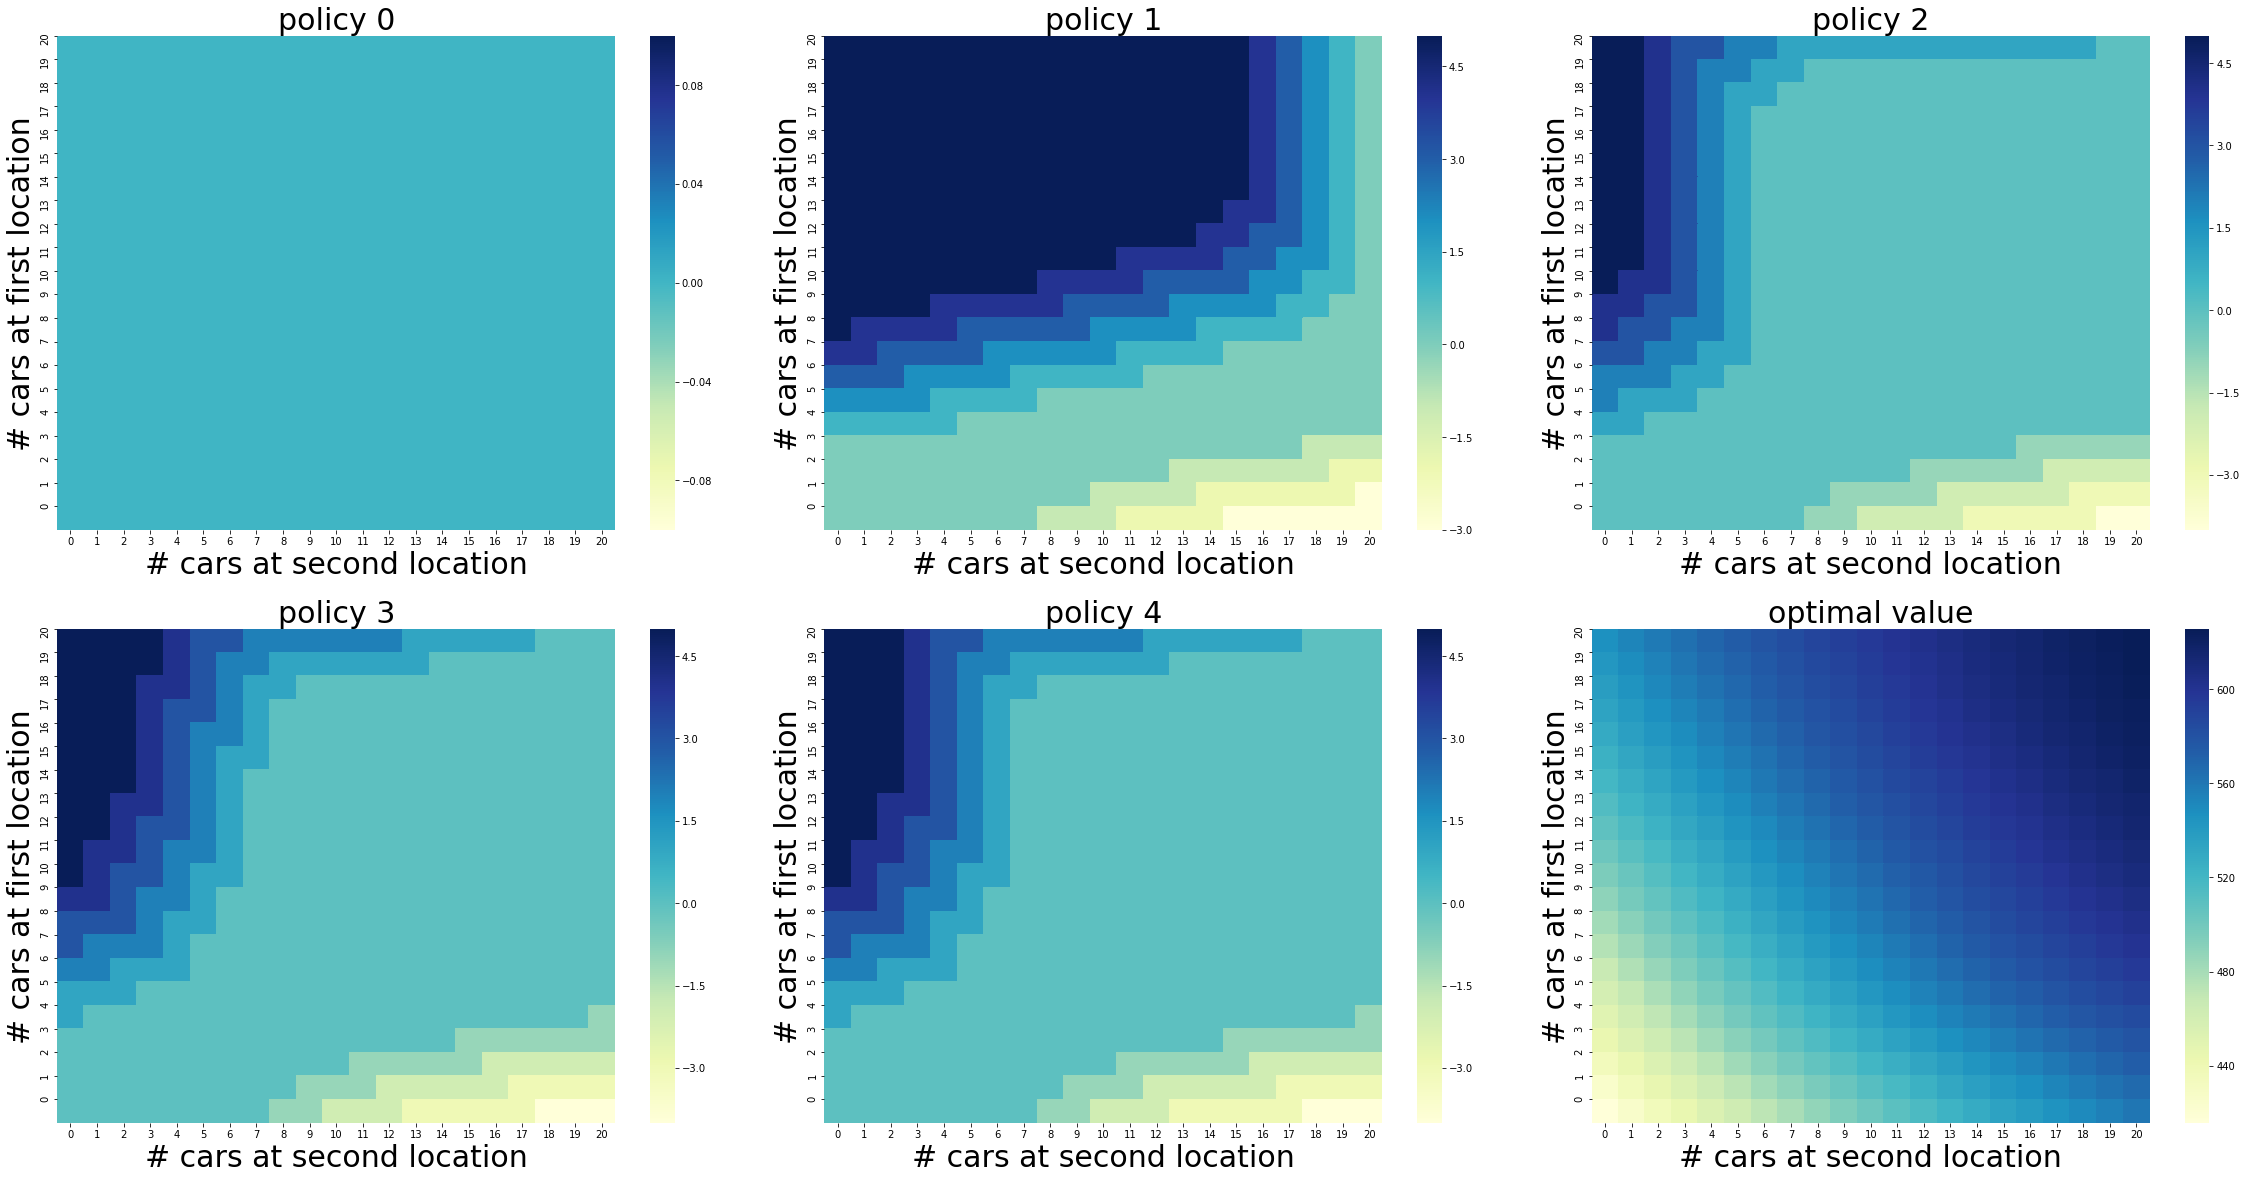

In [7]:
def figure_4_2(constant_returned_cars=True):
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=np.int)

    iterations = 0
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy %d' % (iterations), fontsize=30)

        # policy evaluation (in-place)
        while True:
            new_value = np.copy(value)
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_value[i, j] = expected_return([i, j], policy[i, j], new_value,
                                                      constant_returned_cars)
            value_change = np.abs((new_value - value)).sum()
            print('value change %f' % (value_change))
            value = new_value
            if value_change < 1e-4:
                break

        # policy improvement
        new_policy = np.copy(policy)
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                action_returns = []
                for action in actions:
                    if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-float('inf'))
                new_policy[i, j] = actions[np.argmax(action_returns)]

        policy_change = (new_policy != policy).sum()
        print('policy changed in %d states' % (policy_change))
        policy = new_policy
        if policy_change == 0:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break

        iterations += 1

    plt.show()

figure_4_2()